In [27]:
import pandas as pd
import scipy as sp
from IPython import display
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import csv
from scipy import stats
import itertools
import copy
sb.set(context="poster", font_scale=0.7)

In [28]:
filepath="../analysis/results_from_borel/all_segs/"
numLabels=6

# ATLAS
ATLAS="OASIS_weightier"
filename_3T=filepath + "3T_new/all_segvols_" + ATLAS + ".csv"
filename_64mT=filepath + "64mT_N40_1mm_linear/all_segvols_" + ATLAS + ".csv"

data_3T = pd.read_csv(filename_3T) 
data_64mT = pd.read_csv(filename_64mT) 

In [29]:
#note that these labels start from zero because it's python
CSF=0
Cortex=1
WM=2
Subcortex=3 
Brainstem=4
Cerebellum=5
Ventricles=6

labels = ["Ventricles","Cortex","WhiteMatter","Subcortex","Brainstem","Cerebellum"]

In [30]:
s,pvol = sp.stats.ttest_ind(data_64mT, data_3T, axis=1)
meanvol_64mT = np.array(data_64mT.mean(axis=1))
meanvol_3T = np.array(data_3T.mean(axis=1))
stdvol_64mT = np.array(data_64mT.std(axis=1,ddof=0))
stdvol_3T = np.array(data_3T.std(axis=1,ddof=0))

percent_diff = (meanvol_3T - meanvol_64mT) / ((meanvol_64mT + meanvol_3T)/2) *100

In [31]:
print meanvol_3T
print meanvol_64mT
print stdvol_3T
print stdvol_64mT
print percent_diff

[ 263293.    586058.25  483083.25   36132.25   16989.5   166880.5 ]
[ 163405.1053    638275.209375  540525.119475   27769.074625   18511.932225
  164873.375825]
[ 1484.03992534  1684.49285766  2293.93029264   292.04483817    97.10947431
   427.90215003]
[ 2546.17319612  5197.47398974  3932.82267467   470.92567352   793.16137729
  3260.02074461]
[ 46.81900082  -8.52985908 -11.22340754  26.17528017  -8.57673693
   1.21000797]


In [32]:
# inter and intrasession reliability
sigma_s_3T= np.zeros(numLabels,)
sigma_s_64mT= np.zeros(numLabels,)
sigma_t_3T= np.zeros(numLabels,)
sigma_t_64mT= np.zeros(numLabels,)

data_3T_arr = np.array(data_3T)
data_64mT_arr = np.array(data_64mT)
for i in range(numLabels):
    data_3T_row = data_3T_arr[i,:]
    sigma_s_3T[i]= np.sqrt(np.sum(np.square(data_3T_row[0::2] - data_3T_row[1::2])/ np.shape(data_3T)[1])) 
    sigma_t_3T[i] = np.std(data_3T_row,axis=0,ddof=0)
        
    data_64mT_row = data_64mT_arr[i,:]
    sigma_s_64mT[i]= np.sqrt(np.sum(np.square(data_64mT_row[0::2] - data_64mT_row[1::2])/ np.shape(data_64mT)[1]))
    sigma_t_64mT[i] = np.std(data_64mT_row,axis=0,ddof=0)
    

In [33]:
CV_s_3T = (sigma_s_3T / meanvol_3T)*100
CV_t_3T = (stdvol_3T / meanvol_3T)*100

CV_s_64mT = (sigma_s_64mT / meanvol_64mT)*100
CV_t_64mT = (stdvol_64mT / meanvol_64mT)*100

CV_diff_3T = np.abs(CV_s_3T - CV_t_3T)
CV_diff_64mT = np.abs(CV_s_64mT - CV_t_64mT )  

In [34]:
numPerms=1000
sigma_s_3T_perm = np.zeros((numPerms,numLabels))
sigma_s_64mT_perm = np.zeros((numPerms,numLabels))
sigma_t_3T_perm = np.zeros((numPerms,numLabels))
sigma_t_64mT_perm = np.zeros((numPerms,numLabels))



for j in range(numPerms):
    for i in range(numLabels):
        data_3T_row_perm = np.random.permutation(data_3T_arr[i,:])
        
        sigma_s_3T_perm[j,i]= np.sqrt(np.sum(np.square(data_3T_row_perm[0::2] - data_3T_row_perm[1::2])/ np.shape(data_3T)[1])) 
        sigma_t_3T_perm[j,i] = np.std(data_3T_row_perm,axis=0,ddof=0)

        data_64mT_row_perm = np.random.permutation(data_64mT_arr[i,:])
        sigma_s_64mT_perm[j,i]= np.sqrt(np.sum(np.square(data_64mT_row_perm[0::2] - data_64mT_row_perm[1::2])/ np.shape(data_64mT)[1]))
        sigma_t_64mT_perm[j,i] = np.std(data_64mT_row_perm,axis=0,ddof=0)
        
CV_s_3T_perm = (sigma_s_3T_perm / np.matlib.repmat(meanvol_3T,numPerms,1))*100
CV_t_3T_perm = (sigma_t_3T_perm / np.matlib.repmat(meanvol_3T,numPerms,1))*100

CV_s_64mT_perm = (sigma_s_64mT_perm / np.matlib.repmat(meanvol_64mT,numPerms,1))*100
CV_t_64mT_perm = ( sigma_t_64mT_perm / np.matlib.repmat(meanvol_64mT,numPerms,1))*100

CV_diff_3T_perm = np.abs(CV_s_3T_perm - CV_t_3T_perm)
CV_diff_64mT_perm = np.abs(CV_s_64mT_perm - CV_t_64mT_perm )

In [35]:
# compute difference between inter and intra session reliability - 3T
np.sum((CV_diff_3T_perm >= np.matlib.repmat(CV_diff_3T,numPerms,1)),axis=0)/float(numPerms)

array([ 1.   ,  0.356,  1.   ,  0.318,  0.339,  1.   ])

In [36]:
# compute difference between inter and intra session reliability - 64mT
np.sum((CV_diff_64mT_perm >= np.matlib.repmat(CV_diff_64mT,numPerms,1)),axis=0)/float(numPerms)

array([ 0.393,  0.624,  0.596,  0.791,  0.262,  0.037])

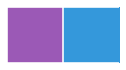

In [41]:
# define color palettes for plots
colors1 = ["#9b59b6", "#3498db"]
colors2 = ["#9b59b6","#9b59b6", "#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db","#3498db"]

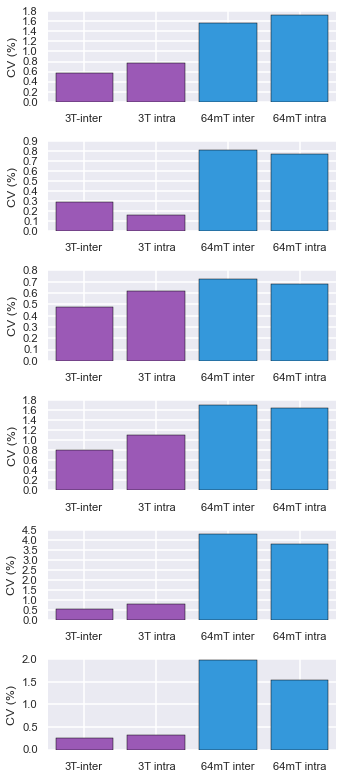

In [38]:
plt.figure(figsize=(5,11))
CVs = ('3T-inter', '3T intra','64mT inter', '64mT intra')
for i in range(numLabels):
    
    plt.subplot(numLabels,1,i+1)
    y_pos = np.arange(len(CVs))
    vals = [CV_t_3T[i],CV_s_3T[i],CV_t_64mT[i],CV_s_64mT[i]]
    plt.bar(y_pos, vals, align='center', color=['#9b59b6','#9b59b6','#3498db','#3498db'])
    plt.xticks(y_pos, CVs)
    plt.ylabel('CV (%)')

plt.tight_layout()

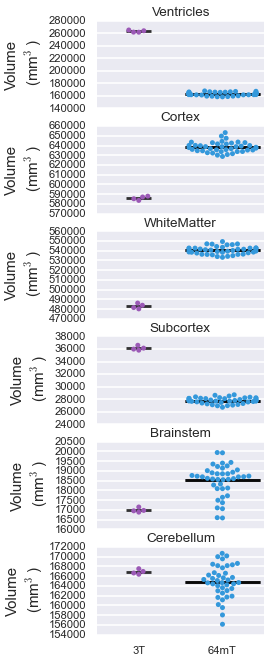

In [39]:
numLabels=6
from matplotlib import pyplot
plt.figure(figsize=(3,11))

for i in range(numLabels):
    plt.subplot(numLabels,1,i+1) 
    plt.title(labels[i])
    pyplot.hlines(meanvol_3T[i], -0.15, 0.15, alpha=0.8,) 
    pyplot.hlines(meanvol_64mT[i], 0.55, 1.45, alpha=0.8) 
    pyplot.hlines(meanvol_64mT[i], 0.55, 1.45, alpha=0.8) 
    axes = sb.swarmplot(data=[data_3T.iloc[i],data_64mT.iloc[i]], alpha=1,palette=colors1)
    
    if i in range(5):
        axes.get_xaxis().set_visible(False)
    
    if i==5:
        a=['3T','64mT']
        axes.set_xticklabels(a)
    
    axes.set_ylabel("Volume\n (mm$^3$)",size=15)
    #axes.set_title(labels[i], rotation='vertical',x=-0.7,y=0.65, loc='center',size=15)
    #plt.tight_layout()

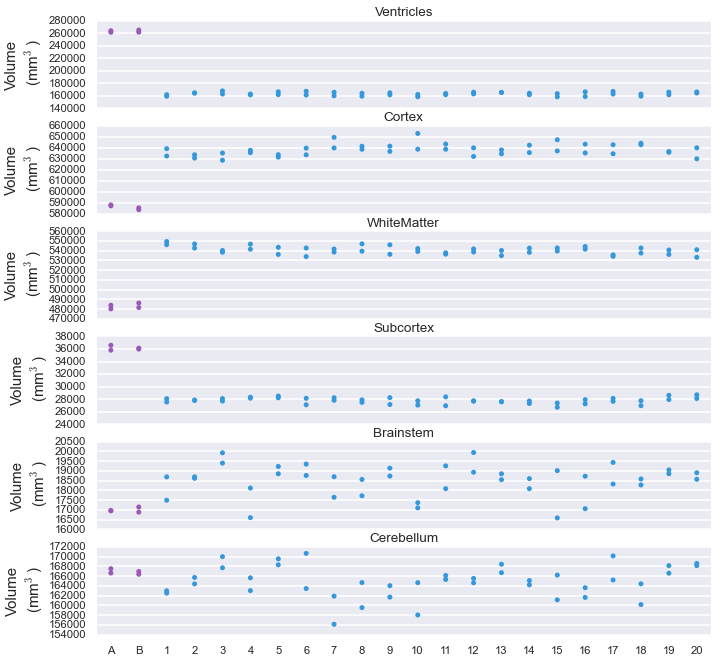

In [40]:
numLabels=6
from matplotlib import gridspec
plt.figure(figsize=(11,11  ))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
for i in range(numLabels):
    plt.subplot(numLabels,1,i+1) 
    plt.title(labels[i])
    axes = sb.stripplot(data=[data_3T.iloc[i,0:2],data_3T.iloc[i,2:4],
                              data_64mT.iloc[i,0:2],data_64mT.iloc[i,2:4],data_64mT.iloc[i,4:6],data_64mT.iloc[i,6:8],
                              data_64mT.iloc[i,8:10],data_64mT.iloc[i,10:12],data_64mT.iloc[i,12:14],data_64mT.iloc[i,14:16],
                              data_64mT.iloc[i,16:18],data_64mT.iloc[i,18:20],data_64mT.iloc[i,20:22],data_64mT.iloc[i,22:24],data_64mT.iloc[i,24:26],
                              data_64mT.iloc[i,26:28],data_64mT.iloc[i,28:30],data_64mT.iloc[i,30:32],data_64mT.iloc[i,32:34],data_64mT.iloc[i,34:36],
                              data_64mT.iloc[i,36:38],data_64mT.iloc[i,38:40]
                             ],jitter=0, alpha=1,palette=colors2)
    a=['A','B','1','2', '3','4','5','6', '7', '8','9','10', '11', '12','13','14', '15', '16','17','18', '19', '20' ]
    axes.set_xticklabels(a)
    axes.set_ylabel("Volume\n (mm$^3$)",size=15)
    
    if i in range(5):
        axes.get_xaxis().set_visible(False)
    
    if i==5:
        a=['A','B','1','2', '3','4','5','6', '7', '8','9','10', '11', '12','13','14', '15', '16','17','18', '19', '20' ]
        axes.set_xticklabels(a)
        
    #axes.set_title("")
    
#plt.tight_layout()
#plt.savefig('3T_vs64mT.pdf')

